# Sinkhorn divergence gradient flows

In [1]:

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence

In [2]:
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)

x = 0.25 * jax.random.normal(key1, (10, 2))  # Source
y = jax.random.normal(key2, (10, 2))

## Defining two distributions

Let us start by defining simple source and target distributions.

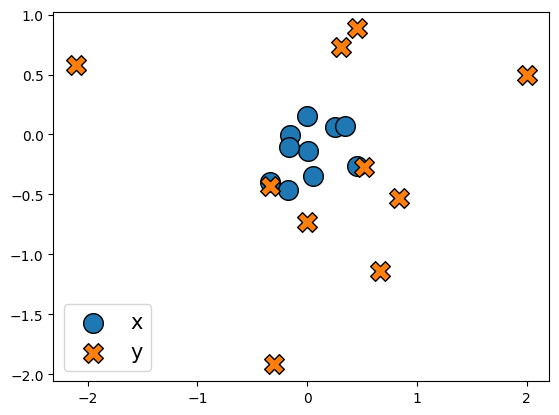

In [3]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=200)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=200)
plt.legend(fontsize=15)
plt.show()

In [4]:
def sink_div(geom,a,b):
    """Return the Sinkhorn divergence cost and OT output given a geometry.
    Since y is fixed, we can use static_b=True to avoid computing
    the OT(b, b) term."""
    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        a=a,
        b=b,
        y=geom.y,
        static_b=True,
    )
    return ot.divergence, ot

In [34]:
def gradient_flow(
    x: jnp.ndarray,
    y: jnp.ndarray,
    a,
    b,
    cost_fn: callable,
    num_iter: int = 1_000,
    lr: float = 0.05,
    dump_every: int = 50,
    epsilon: float = 0.1,
):
    """Compute a gradient flow."""

    ots = []
    cost_fn_vg = jax.jit(jax.value_and_grad(cost_fn, has_aux=True))
    for i in range(0, num_iter + 1):
        geom = pointcloud.PointCloud(x, y)
        (cost,ot), geom_g = cost_fn_vg(geom, a, b)
        assert ot.converged
        #a = jax.nn.softmax(a - geom_g[1] * lr)
        x = x - geom_g.x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [35]:
def display_animation(ots, plot_class=plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, frame_rate=4)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

For the default value of $\varepsilon$, the gradient flow behaves as expected:

In [38]:
geom = pointcloud.PointCloud(x, y)

marginal_a = jax.random.normal(key1, shape=(10, ))
marginal_b = jax.random.normal(key2, shape=(10, ))
marginal_a = jax.nn.softmax(marginal_a)
marginal_b = jax.nn.softmax(marginal_b)
# marginal_a /= jnp.sum(marginal_a)
# marginal_b /= jnp.sum(marginal_b)

In [41]:
marginal_a.sum()

Array(1., dtype=float32)

In [42]:
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y

ots = gradient_flow(x, y, a=marginal_a, b=marginal_b, cost_fn=sink_div, epsilon=0.2)
display_animation(ots, plot_class=CustomPlot)